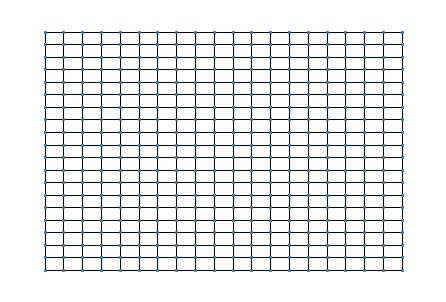

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.grid_2d_graph(range(-10,10),range(-10,10))
pos = {(x,y):(x,y) for x,y in G.nodes()}
nx.draw(G,pos= pos,node_size=5)
plt.show()